# Сomputer Vision task of Image Classification

## Import the libraries


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from PIL import Image

import pathlib
import splitfolders

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [ ]:
root_path = "/content/Rice_Image_Dataset"
root_path = pathlib.Path(root_path)

In [ ]:
splitfolders.ratio(input=root_path, output='rice_images', seed=42, ratio=(0.7, 0.3))

Copying files: 75000 files [01:01, 1213.85 files/s]


In [ ]:
data_direction = "/content/rice_images"
data_direction = pathlib.Path(data_direction)

## Preprocessing the Dataset

Preprocessing steps:
- Resizing the images to a consistent size using `transforms.Resize`.
- Converting the images into PyTorch tensors using `transforms.ToTensor`.
- Normalizing the pixel values using the mean and standard deviation values using `transforms.Normalize`. This step is a common practice for preparing data for neural networks.

In [ ]:
data_transform = torchvision.transforms.Compose([transforms.ToTensor(),
                                                 transforms.Normalize((0.5),(0.5)),
                                                 transforms.Resize((128, 128))])

## Creating Data Loaders

In this section, we load and preprocess the rice image dataset using PyTorch's `ImageFolder` dataset class. The dataset is organized into class-specific folders, and transformations are applied to prepare the data for model training. Next step `DataLoader`. It provides an iterable over the given dataset. It can shuffle the data, sample data, and load the data in parallel using multiprocessing workers. It also provides useful features such as batching, normalization, and dataset indexing.

In [ ]:
train_set = ImageFolder(data_direction.joinpath("train"), transform=data_transform)
print("Tarin", train_set, "\n")
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = ImageFolder(data_direction.joinpath("val"), transform=data_transform)
print("Test", test_set, "\n")
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=2)


classes = ("Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag")

Tarin Dataset ImageFolder
    Number of datapoints: 52500
    Root location: /content/rice_images/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
           ) 

Test Dataset ImageFolder
    Number of datapoints: 22500
    Root location: /content/rice_images/val
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
           ) 



In [ ]:
train_iter = iter(train_set)
image, label = next(train_iter)

image.shape, label

(torch.Size([3, 128, 128]), 0)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


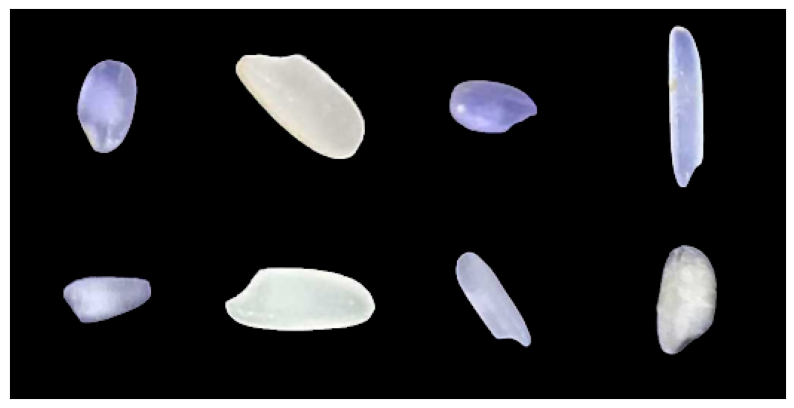

In [ ]:
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

# CNN Model

In [ ]:
class CNN_Model(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## The tasks of Each Layer in the CNN Model.

1. **Convolutional Layer 1:**
- This is the first convolutional layer. It takes an input image with 3 channels (typically RGB for color images) and outputs 16 feature maps. The kernel size is 3, meaning a 3x3 filter is used. The padding is set to 1, which means a 1-pixel border is added around the image before convolution, helping to maintain the spatial dimensions of the image.

2. **Convolutional Layer 2:**
- This is the second convolutional layer. It takes the 16 feature maps from the first layer and outputs 32 feature maps. The kernel size and padding are the same as in the first layer.

3. **Max Pooling Layer:**
- This is the max pooling layer. It reduces the spatial dimensions (width and height) of the feature maps by taking the maximum value over a 2x2 window. The stride is set to 2, which means the window moves 2 pixels at a time.

4. **Fully Connected Layer 1:**
- This is the first fully connected layer. It takes the flattened feature maps from the previous layer and outputs 128 features. The input size is calculated as 32 (the number of feature maps from the second convolutional layer) times 32 (the spatial dimensions of the feature maps after pooling) squared.

5. **Fully Connected Layer 2:**
- This is the second and final fully connected layer. It takes the 128 features from the first fully connected layer and outputs the number of classes specified by num_classes. This is the output layer of the model, which produces the class scores for each class.

## Defining Loss Function and Optimizer

In [ ]:
num_classes = len(classes)
cnn_model = CNN_Model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

**Adam Optimizer:** Adam (Adaptive Moment Estimation) is a method that computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adagrad, Adam also keeps an exponentially decaying average of past gradients, similar to momentum.

**Cross-Entropy Loss:** Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.

In [ ]:
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

epochs = 5

## Training and Test Loop

In [ ]:
for epoch in range(epochs):
    start = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    test_epoch_loss = []
    test_epoch_accuracy = []

    cnn_model.train()
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Train'):
        optimizer.zero_grad()
        preds = cnn_model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        preds = F.softmax(preds, dim=1)
        _, predicted = torch.max(preds.data, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)

        train_epoch_loss.append(loss.item())
        train_epoch_accuracy.append(acc)

    cnn_model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} Test'):
            preds = cnn_model(images)
            loss = criterion(preds, labels)

            preds = F.softmax(preds, dim=1)
            _, predicted = torch.max(preds.data, 1)
            acc = (predicted == labels).sum().item() / labels.size(0)

            test_epoch_loss.append(loss.item())
            test_epoch_accuracy.append(acc)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    test_epoch_loss = np.mean(test_epoch_loss)
    test_epoch_accuracy = np.mean(test_epoch_accuracy)

    end = time.time()

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.4f}, Test Loss: {test_epoch_loss:.4f}, Test Acc: {test_epoch_accuracy:.4f}, Time: {end-start:.2f}s")

Epoch 1/5 Train:   0%|          | 0/6563 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/5 Train: 100%|██████████| 6563/6563 [18:59<00:00,  5.91it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/5 Test: 100%|██████████| 2813/2813 [02:38<00:00, 17.74it/s]


Epoch 1/5, Train Loss: 0.0987, Train Acc: 0.9651, Test Loss: 0.0584, Test Acc: 0.9819, Time: 1298.39s


Epoch 2/5 Test: 100%|██████████| 2813/2813 [02:36<00:00, 17.94it/s]


Epoch 2/5, Train Loss: 0.0291, Train Acc: 0.9903, Test Loss: 0.0211, Test Acc: 0.9946, Time: 1321.17s


Epoch 3/5 Test: 100%|██████████| 2813/2813 [02:35<00:00, 18.11it/s]


Epoch 3/5, Train Loss: 0.0247, Train Acc: 0.9923, Test Loss: 0.0204, Test Acc: 0.9938, Time: 1338.50s


Epoch 4/5 Test: 100%|██████████| 2813/2813 [02:37<00:00, 17.89it/s]


Epoch 4/5, Train Loss: 0.0200, Train Acc: 0.9940, Test Loss: 0.0282, Test Acc: 0.9920, Time: 1334.22s


Epoch 5/5 Test: 100%|██████████| 2813/2813 [02:39<00:00, 17.68it/s]

Epoch 5/5, Train Loss: 0.0174, Train Acc: 0.9947, Test Loss: 0.0205, Test Acc: 0.9939, Time: 1341.90s


As can be seen from the accuracy, our model has learned to classify rice pictures almost perfectly. Our CNN model has done well in this task, now let's try to do the same but using transfer learning.

## Visualization of results

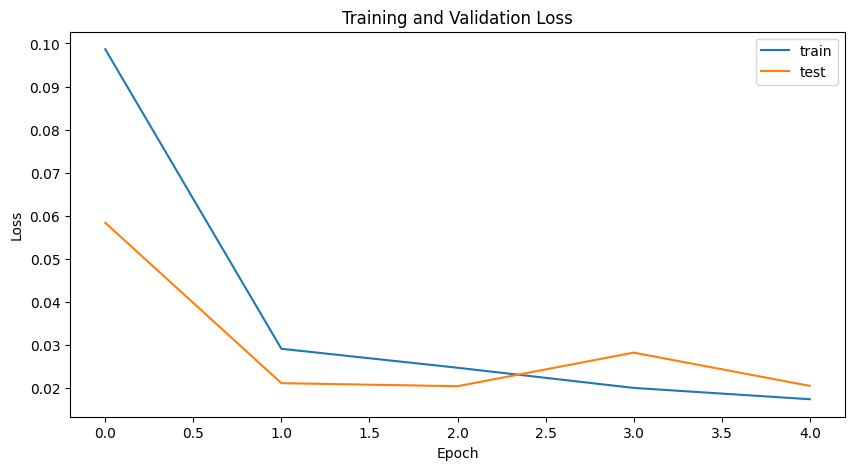

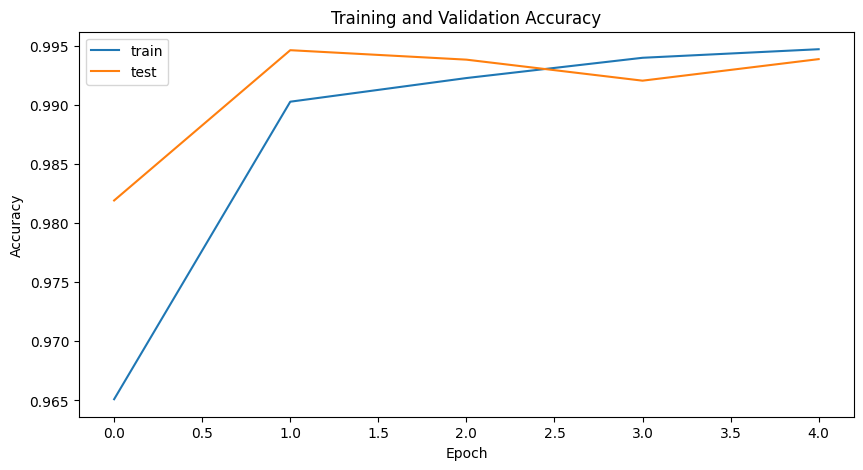

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_loss, label="train")
plt.plot(test_loss, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot(train_accuracy, label="train")
plt.plot(test_accuracy, label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Random image test

In [ ]:
image = Image.open('/content/rice_images/val/Jasmine/Jasmine (10012).jpg')

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])
image = transform(image).unsqueeze(0)

cnn_model.eval()
with torch.no_grad():
    preds = cnn_model(image)
    preds = F.softmax(preds, dim=1)

_, predicted_class = torch.max(preds, 1)

print(f'Predicted class: {predicted_class.item()}')

Predicted class: 3


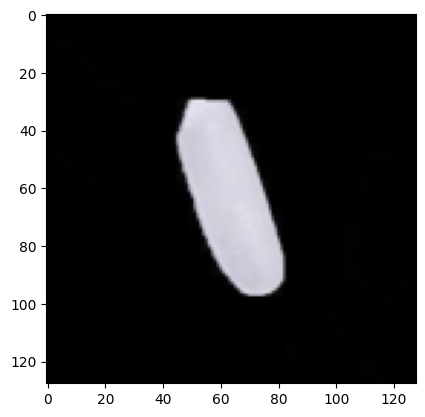

In [ ]:
image = image.squeeze(0).numpy().transpose((1, 2, 0))
image = (image * 0.5) + 0.5
plt.imshow(image)
plt.show()

# Transfer learning - MobileNet v2

## Adding a MobileNet v2 Model

`MobileNetV2` is a lightweight model that was introduced by Google in 2018. It is based on an inverted residual structure where the shortcut connections are between the thin bottleneck layers. `MobileNetV2` uses depthwise separable convolutions to build lightweight deep neural networks.

The main idea behind `MobileNetV2` is to use a linear bottleneck layer that preserves information by using a 1x1 convolution before the 3x3 depthwise convolution. This is followed by another 1x1 convolution which allows the network to learn more complex patterns.

Here are some key features of `MobileNetV2`:

- **Linear Bottlenecks:** `MobileNetV2` uses linear bottleneck layers that have a small number of channels (e.g., 16) and thus require less computation.

- **Inverted Residuals:** `MobileNetV2` uses inverted residuals which are a combination of a pointwise convolution and a depthwise convolution. This structure helps to reduce the computational cost.

- **Width Multiplier:** `MobileNetV2` introduces a width multiplier that allows the model designer to reduce the computational cost by reducing the number of channels in the network.

- **Efficient Architecture:** The architecture of `MobileNetV2` is efficient and can be used for various applications like image classification, object detection, and semantic segmentation.

- **Regularization:** `MobileNetV2` uses dropout as a regularization technique to prevent overfitting.

In [ ]:
mobilenet = models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 19.8MB/s]


## MobileNet v2 Model with Freeze Function

In [ ]:
for param in mobilenet.parameters():
    param.requires_grad = False

num_features = mobilenet.classifier[-1].in_features
mobilenet.classifier[-1] = nn.Linear(num_features, num_classes)

for param in mobilenet.classifier[-1].parameters():
    param.requires_grad = True

## Defining Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters())

## Training and Test Loop

In [ ]:
def train(model, criterion, optimizer, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        with tqdm(train_loader, unit="batch") as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total}%')

In [ ]:
num_epochs = 2
train(mobilenet, criterion, optimizer, train_loader, num_epochs)

test(mobilenet, test_loader)

  0%|          | 0/6563 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/2: 100%|██████████| 6563/6563 [19:04<00:00,  7.01batch/s, loss=0.0224]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/2: 100%|██████████| 6563/6563 [19:04<00:00,  5.73batch/s, loss=0.0224]


Epoch [1/2], Loss: 0.02242356911301613


Epoch 2/2: 100%|██████████| 6563/6563 [19:07<00:00,  5.72batch/s, loss=1.16]

Epoch [2/2], Loss: 1.1632168292999268


Accuracy: 99.64444444444445%


Awesome! The MobileNet v2 model also performed well on this dataset.